In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In this notebook, we test a simple implementation of Naive Bayes classifier for a categorical dataset. Naive Bayes is based on applying Bayes theorem and assumes independence between input variables. 

## Generate toy_categorical_dataset

In [3]:
cond_probs_feat_a = pd.DataFrame(data = [[0.2, 0.1, 0.7],
                                         [0.5, 0.3, 0.2]], 
                                 columns = ['value_1', 'value_2', 'value_3'],
                                 index = ['class_a', 'class_b'])
cond_probs_feat_a

,value_1,value_2,value_3
class_a,0.2,0.1,0.7
class_b,0.5,0.3,0.2


In [4]:
cond_probs_feat_b = pd.DataFrame(data = [[0.8, 0.2],
                                         [0.4, 0.6]], 
                                 columns = ['value_1', 'value_2'],
                                 index = ['class_a', 'class_b'])
cond_probs_feat_b

,value_1,value_2
class_a,0.8,0.2
class_b,0.4,0.6


In [5]:
cond_probs_feat_c = pd.DataFrame(data = [[0.1, 0.2, 0.3, 0.4],
                                         [0.9, 0.02, 0.05, 0.03]], 
                                 columns = ['value_1', 'value_2', 'value_3', 'value_4'],
                                 index = ['class_a', 'class_b'])
cond_probs_feat_c

,value_1,value_2,value_3,value_4
class_a,0.1,0.20,0.30,0.40
class_b,0.9,0.02,0.05,0.03


In [6]:
prob_class = pd.Series([0.4, 0.6], index = ['class_a', 'class_b'])
prob_class

class_a    0.4
class_b    0.6
dtype: float64

In [7]:
data = []
classes = []
for i in range(1000):
    observed = []
    # Sampling class label
    if np.random.rand() > prob_class.loc['class_a']:
        classes.append('class_b')
    else:
        classes.append('class_a')
    # Sampling features
    for cond_probs in [cond_probs_feat_a, cond_probs_feat_b, cond_probs_feat_c]:
        df = cond_probs.loc[classes[-1]].cumsum()
        observed.append(df[df > np.random.rand()].index.values[0])
    
    data.append(observed)

In [8]:
data = pd.DataFrame(data = data, columns = ['feature_a', 'feature_b', 'feature_c'])
data['class'] = classes
data.head()

,feature_a,feature_b,feature_c,class
0,value_2,value_2,value_1,class_b
1,value_2,value_2,value_1,class_b
2,value_1,value_2,value_1,class_b
3,value_3,value_1,value_1,class_b
4,value_3,value_1,value_4,class_a


## Visualise the data

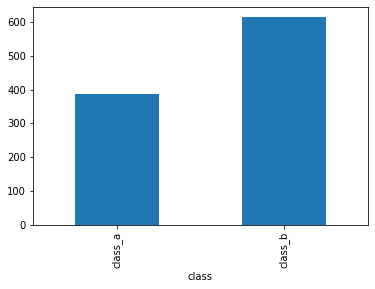

In [9]:
_ = data.groupby('class')['class'].count().plot.bar()

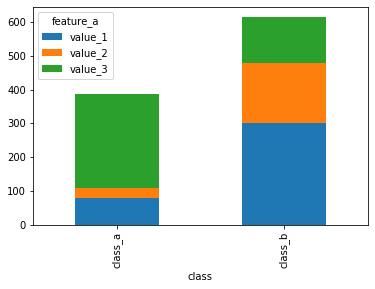

In [10]:
_ = data.groupby(['class', 'feature_a'])['feature_a'].count().unstack('feature_a').plot.bar(stacked = True)

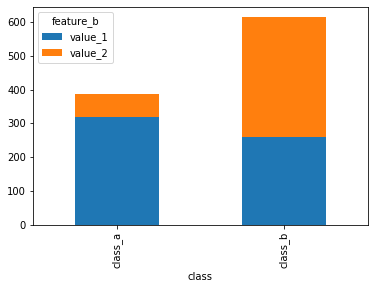

In [11]:
_ = data.groupby(['class', 'feature_b'])['feature_b'].count().unstack('feature_b').plot.bar(stacked = True)

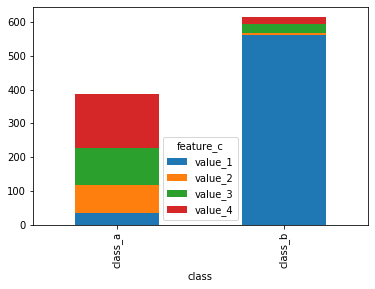

In [12]:
_ = data.groupby(['class', 'feature_c'])['feature_c'].count().unstack('feature_c').plot.bar(stacked = True)

## Without laplacian smoothing

### Fit the model

We use 80% of the data

### Predict test data

Using the 20% remaining data. 

## Laplacian smoothing

### Fit the model

### Predict test data